# Dog Breed Classification
This Google Colab notebook will perform end-to-end multi-class image classification using
TensorFlow and TensorFlow Hub.

## Problem
Given an image, predict the breed of dog.

## Data
Data is from Kaggle Dog-Breed Identification Competition.

## Evaluation
The evaluation is a file of prediction probabilities of each dog breed for each image.

www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## Features
* We will use deep learning/transfer learning as the data isunstructured.
* There are 120 breeds (classes)
* There are 10000+ images in the training set with labels
* There are 10000+ images in the test set without labels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
import os


In [ ]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Setting up workspace

In [ ]:
# Unzipping the data
# !unzip "/content/drive/MyDrive/DogVision/dog-breed-identification.zip" -d "/content/drive/MyDrive/DogVision"


In [ ]:
labels_csv = pd.read_csv("/content/drive/MyDrive/DogVision/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126


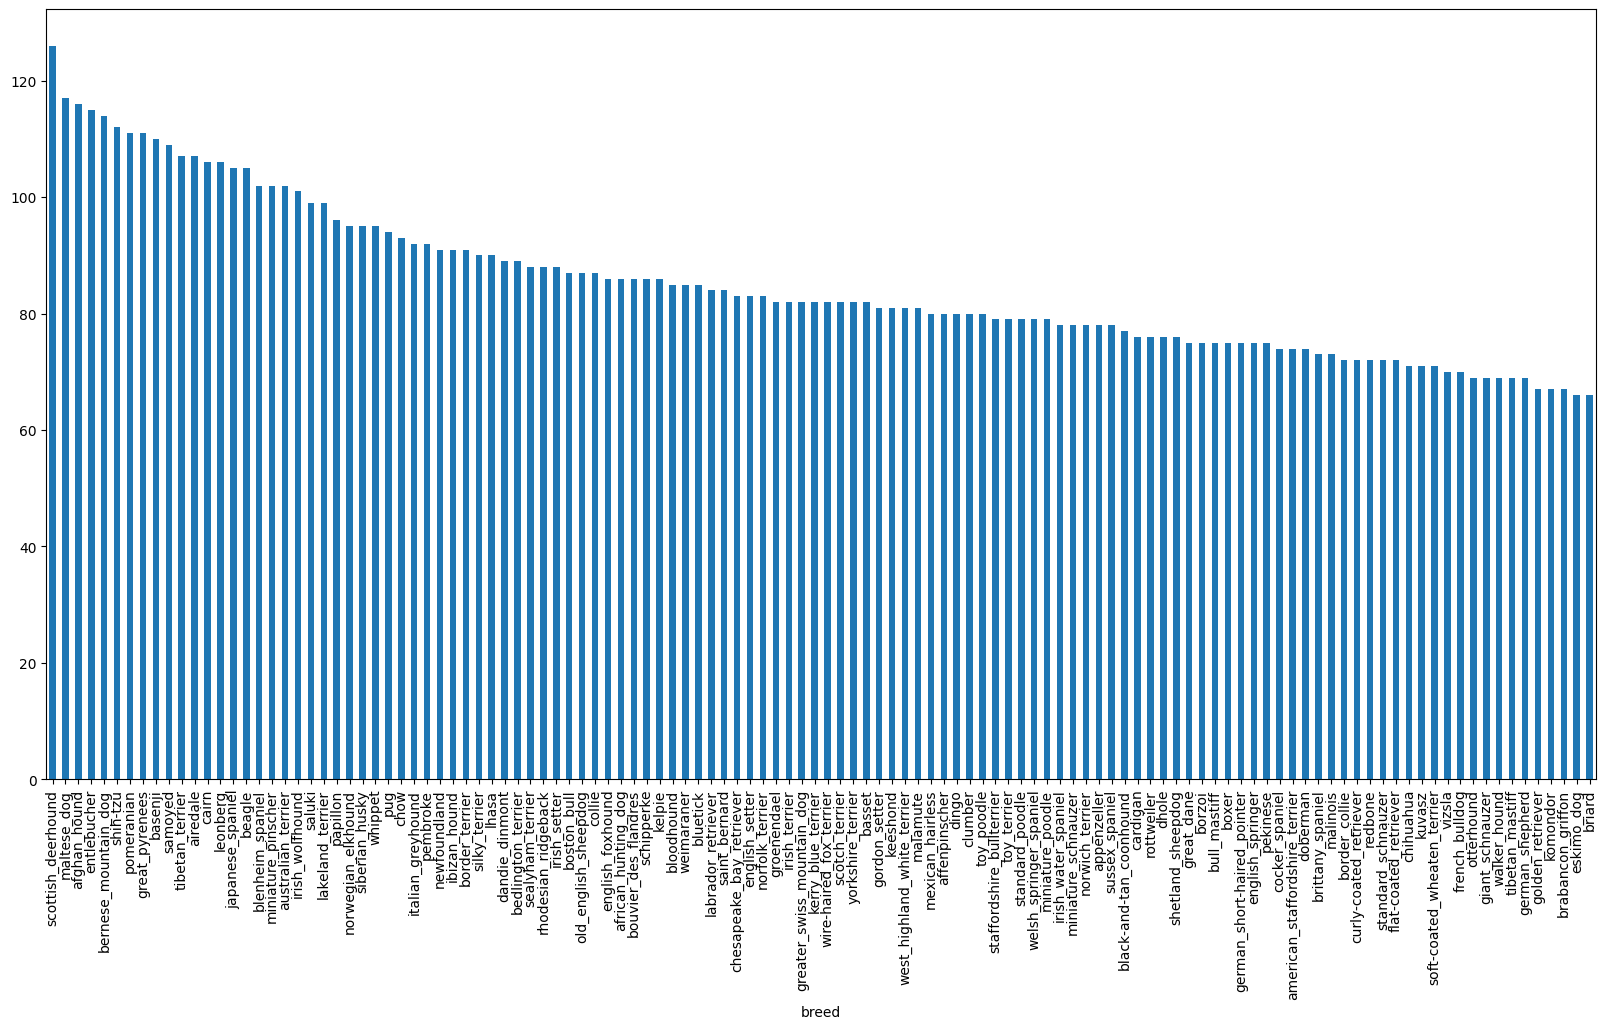

In [ ]:
# images per breed
labels_csv['breed'].value_counts().plot.bar(figsize=(20,10));


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
from IPython.display import Image
training_file_names = [f"/content/drive/MyDrive/DogVision/train/{fname}.jpg" for fname in labels_csv['id']]
training_file_names[0]
#Image("/content/drive/MyDrive/DogVision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

'/content/drive/MyDrive/DogVision/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

### Matching
Checking if the number of files in labels.csv matches the actual number of files.

In [ ]:
if len(os.listdir("/content/drive/MyDrive/DogVision/train/")) == len(training_file_names):
    print("Success")
else:
    print("Failure")

Success


In [ ]:
labels = labels_csv['breed'].to_numpy()
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
boolean_labels = [label == unique_breeds for label in labels]

In [ ]:
# Set up X and y variables for making a validation set
X = training_file_names
y = boolean_labels

Initially using 1000 images and increasing iterably.

In [ ]:
NUM_IMAGES = 1000 #@param {"type": "slider", "min": 1000, "max": 10000, "step": 1000}

In [ ]:
# splitting data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X[:NUM_IMAGES],
                                                      y[:NUM_IMAGES],
                                                      test_size=0.2,
                                                      random_state=42)
len(X_train), len(y_train), len(X_valid), len(y_valid)

(800, 800, 200, 200)

In [ ]:
X_train[1], y_train[1]

('/content/drive/MyDrive/DogVision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, Fals

### Turning Images into Tensors
1. Take an image's filepath
2. Use TensorFlow to store the image as a variable. (`image`)
3. Convert the `image` to a tensor
4. Normalize the `image` from values of 0-255 to 0-1
5. Resize the `image` to 224x224
6. Return the `image`

In [ ]:
# importing an image
image = plt.imread(training_file_names[2])
image.shape

(375, 500, 3)

In [ ]:
IMAGE_SIZE = 224
def image_to_tensor(img_path, img_size=IMAGE_SIZE):
    """
    Takes an image filepath and turns the image into a tensor
    """
    # read in the file path
    image = tf.io.read_file(img_path)
    # turn the jpeg into a numerical tensor with RGB colour channels
    image = tf.image.decode_jpeg(image, channels=3)
    # turn the colour channels values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # resize the image to 224x224
    image = tf.image.resize(image, size=[img_size, img_size])

    return image

The whole dataset at once is too much to process, so we make batches.

In [ ]:
def get_image_label(image_path, label):
    """Takes the image_path and associated label,
    and processes the image, and returns a tuple of
    (image, label)"""
    image = image_to_tensor(image_path)
    return (image, label)


we've now turned the data into tuples of tensors, now we turn the entire dataset into batches

In [ ]:
# turning data into batches
BATCH_SIZE = 32
def create_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches out of the X and y parts of the data,
    Shuffles the data if it's training data, but doesn't shuffle if it's
    validation data.
    Also accepts test data (with no labels)
    """
    tnX = tf.constant(X) # file paths
    tny = tf.constant(y) # labels

    # if the data is a test set
    if test_data:
        print("Creating test data batches:")
        data = tf.data.Dataset.from_tensor_slices(tnX)
        data_batch = data.map(image_to_tensor).batch(batch_size)
        return data_batch

    # if the data is a validation set, no shuffling required
    elif valid_data:
        print("Creating validation data batches:")
        data = tf.data.Dataset.from_tensor_slices((tnX, tny))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

    else:
        print("Creating training data batches:")
        data = tf.data.Dataset.from_tensor_slices((tnX, tny))
        # shuffling pathnames and labels
        data = data.shuffle(buffer_size=len(X))
        # creating (image, label) tuples and turn the data into batches
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

In [ ]:
train_data = create_batches(X_train, y_train)
val_data = create_batches(X_valid, y_valid, valid_data=True)

Creating training data batches:
Creating validation data batches:


## Visualizing Batches

In [ ]:
def show_25_images(images, labels):
    """
    Displays 25 images and their labels from a batch
    """
    plt.figure(figsize=(10,10))

    for i in range(25):
        # Create subplots
        ax = plt.subplot(5,5,i+1)
        # Display image
        plt.imshow(images[i])
        # Add label
        plt.axis("off")
        plt.title(unique_breeds[labels[i].argmax()])

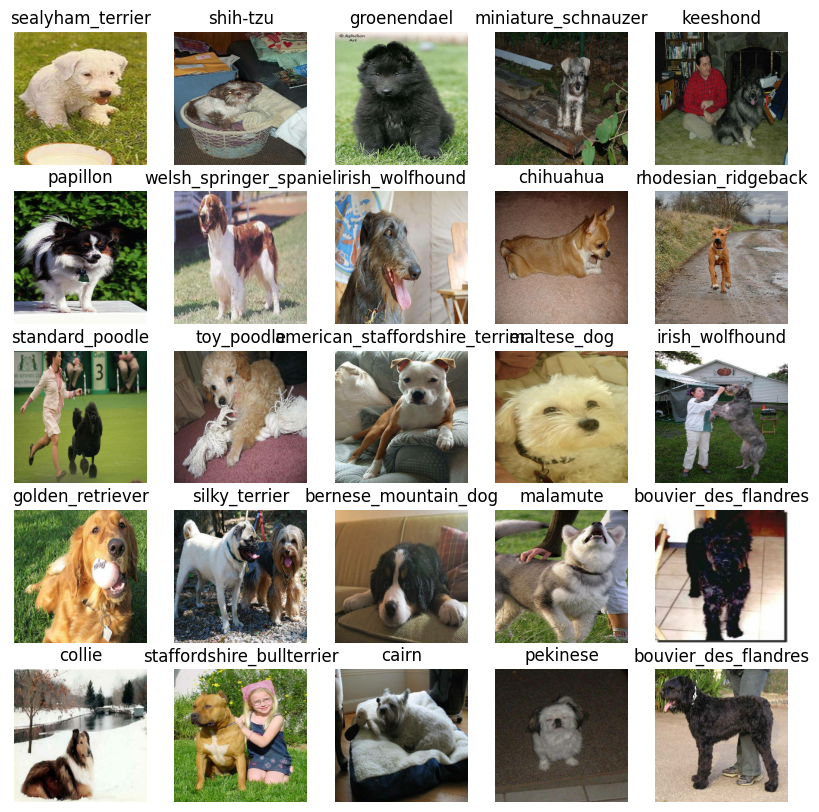

In [ ]:
train_data_sample = train_data.take(1)
train_images, train_labels = next(train_data_sample.as_numpy_iterator())
show_25_images(train_images, train_labels)

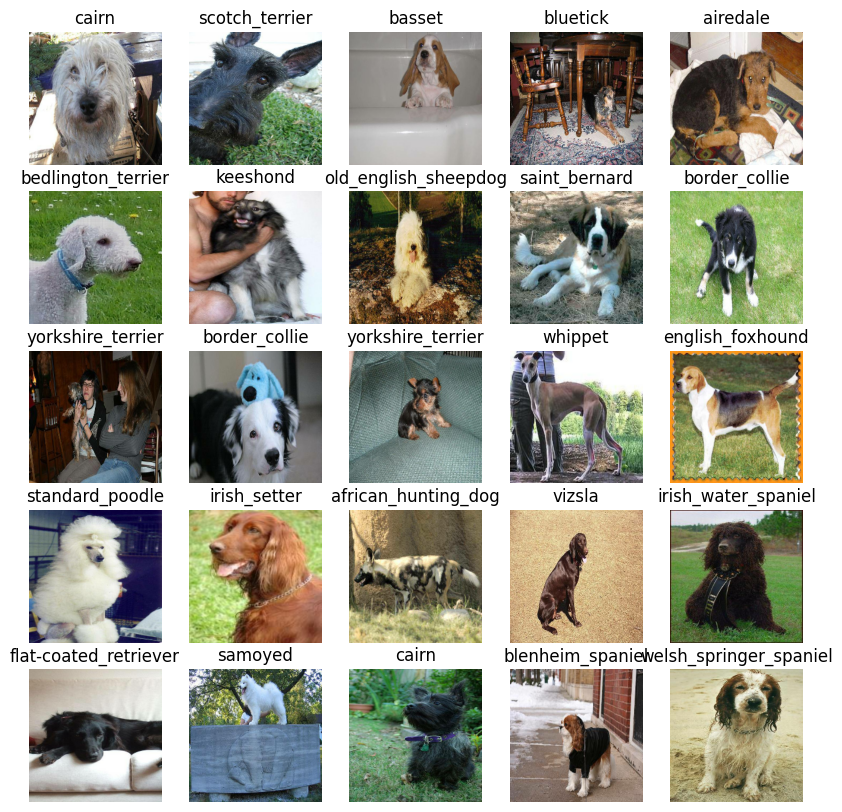

In [ ]:
val_data_sample = val_data.take(1)
val_images, val_labels = next(val_data_sample.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building the model
We need to define a few things before building the model
- The input shape (our image shape, in the form of Tensors) to our model.
- The output shape (image labels, in the form of Tensors) to our model.
- The URL of the model we want to use.


In [ ]:
INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3] # batch, height, width, colour channels
OUTPUT_SHAPE = len(unique_breeds) # number of output labels
MODEL_URL = "https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1"

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", model_url)

    # setup the model layers
    model = tf_keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1: input layer
        tf_keras.layers.Dense(units=output_shape,
                              activation="softmax") # Layer 2: output layer

    ])
    # compile the model
    model.compile(
        loss=tf_keras.losses.CategoricalCrossentropy(),
        optimizer=tf_keras.optimizers.Adam(),
        metrics=["accuracy"]
    )
    # build the model
    model.build(input_shape=input_shape)

    return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://kaggle.com/models/google/mobilenet-v2/TensorFlow2/130-224-classification/1
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________
